# TLS Characterization of UA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 2 # for UA Q3
res_index = 2 # for UA Q3
flux_index = 2 # for UA Q3
TLS_index = 0

2024-04-19 15:58:23,369 - qm - INFO     - Starting session: 05e4bd4c-32d8-45a6-86b0-b7473caf008f


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [5]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

In [3]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-17 09:19:03,914 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-04-17 09:19:03,919 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-17 09:19:03,934 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-17 09:19:12,083 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (4.517 GHz, 200.000 MHz)
2024-04-17 09:19:26,523 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


# TLS experiments

## Set TLS index

In [3]:
TLS_index = 2

## TLS T1

In [126]:
# set to qubit freq
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 100E6
machine = Analysis.set_machine(machine)

In [5]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-04-17 09:19:46,651 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-17 09:19:46,664 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-17 09:19:55,059 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (4.517 GHz, 200.000 MHz)
2024-04-17 09:20:09,460 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [298]:
%matplotlib qt
tau_sweep_abs = np.arange(200,500E3+1,2E4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 160.16s
Execution stopped by user!


Qubit T1 [us]: 34.6164851005693


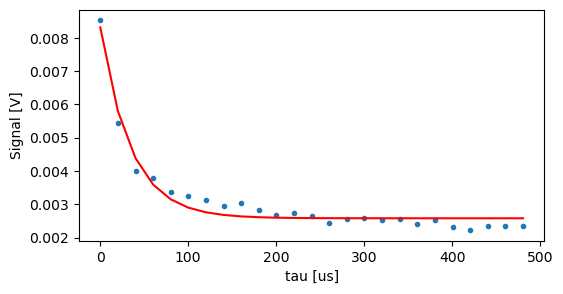

In [300]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

# TLS drive

## TLS spectroscopy

### This cell is only for the first run, to estimate TLS freq

In [ ]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

### This is when we already have calibrated TLS freq saved somewhere

In [4]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [5]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-04-12 12:39:54,209 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-04-12 12:39:54,213 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-12 12:39:54,230 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-12 12:40:01,995 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (4.514 GHz, 200.000 MHz)
2024-04-12 12:40:15,353 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [32]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-3E6,3E6+1,0.2E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 80.66s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 80.75s


In [ ]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-150E6,150E6+1,1E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 800E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

resonant frequency: 4715.011 MHz


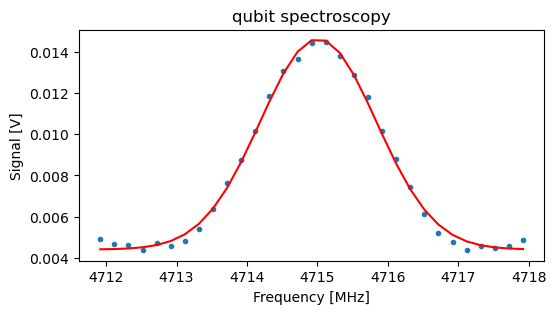

In [34]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

In [35]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-04-22 09:15:52,822 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-22 09:15:52,860 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-22 09:16:01,044 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (4.515 GHz, 200.000 MHz)
2024-04-22 09:16:15,447 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Quantum jumps in TLS frequency

In [18]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-3E6,3E6+1,0.2E6)
N_rounds = 650

machine, TLS_freq_sweep, tau, sig_amp, sig_phase = Experiment.exp2D.time.TLS_freq_time(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  N_rounds, n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=650/650) --> elapsed time: 55240.08s


## TLS rabi

In [12]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 180 + 0.1, 5)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 93.90s


T2rabi: 8352.8 ns
rabi_pi_pulse: 370.6 ns
half period: 347.55 ns


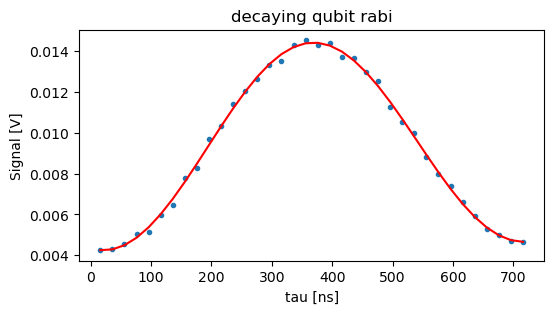

In [14]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [26]:
pi_length = 372
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(pi_length)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = pi_length
    
machine.qubits[qubit_index].pi_length_tls[0] = pi_length
machine = Analysis.set_machine(machine)

In [23]:
machine.qubits[qubit_index].rf_gain = 0
machine = Analysis.set_machine(machine)

## TLS Power Rabi

In [27]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 1, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 10_000,plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 46.78s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 46.90s


rabi_pi_pulse_amp: 0.46742 V
half period: 0.4370451 V


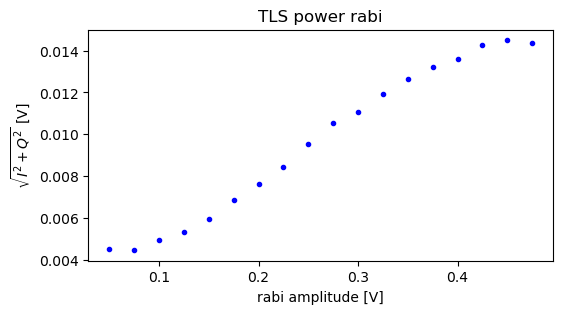

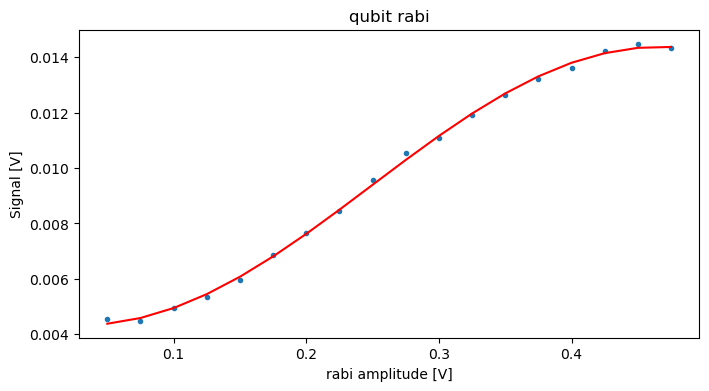

Execution stopped by user!


In [11]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [166]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine.qubits[qubit_index].pi_length_tls[0] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [11]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1000 + 0.1, 2)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_I = Experiment.exp1D.Ramsey.TLS_ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 10E3, detuning = 7E6, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 2612.76s


Qubit T2* [ns]: 661.1563263983008
Detuning [MHz]: 7.123657739112519
Exponent n: 1.261399606862469


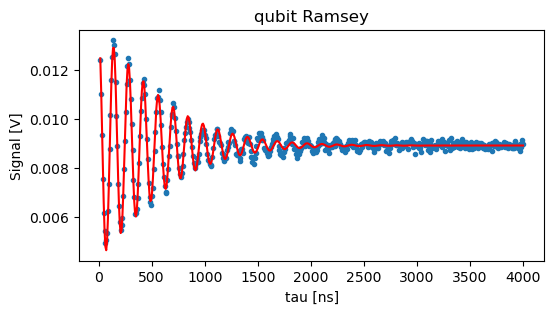

In [13]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_I,plot_flag = True)

## TLS T1 with direct driving

In [49]:
%matplotlib qt
tau_sweep_abs = np.arange(200,500E3+1,2E4)
machine, tau_sweep_abs, sig_I = Experiment.exp1D.T1.TLS_T1_driving(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 157.64s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 157.77s


Qubit T1 [us]: 26.667463057069085


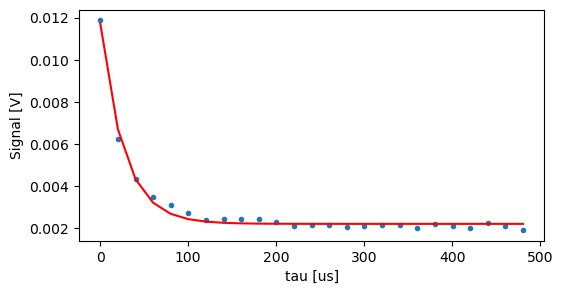

In [51]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_I,method = "exp")

# TLS Dynamical Decoupling

In [36]:
#Parameters for DD sequences
min_tau = 4
max_tau = 600
d_tau = 1

## TLS echo

In [54]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_echo(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 834.88s


Qubit T1 [us]: 2027.359931548211


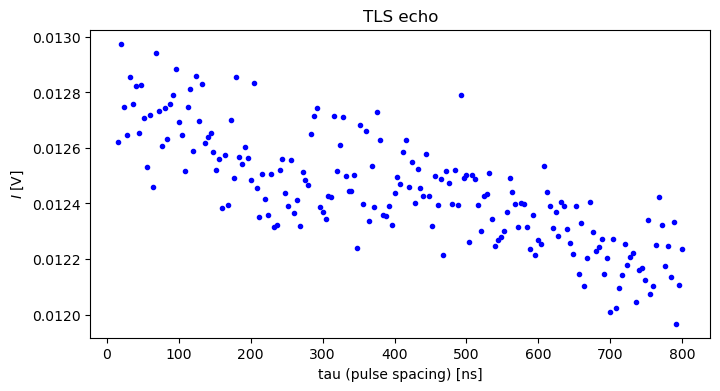

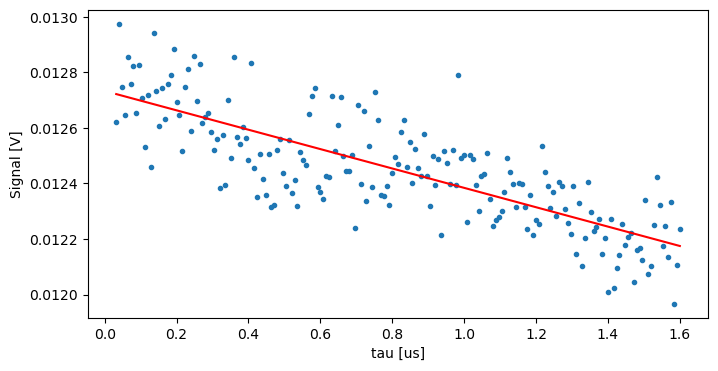

Execution stopped by user!


In [55]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG2

In [16]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 2, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3147.65s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3147.79s


## TLS CPMG4

In [17]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 4, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3180.83s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3180.97s


## TLS CPMG6

In [39]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 6, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = True, simulation_len = 20_000, machine = machine)

TypeError: cannot unpack non-iterable NoneType object

## TLS CPMG8

In [19]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 8, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3247.59s


## TLS CPMG 10

In [20]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 10, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3280.97s


## TLS CPMG12

In [21]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 12, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3314.09s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3314.28s


## TLS CPMG 14

In [22]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 14, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3347.43s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3347.61s


## TLS CPMG16

In [23]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 16, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3380.74s


## TLS CPMG 18

In [24]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 18, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3414.16s


## TLS CPMG20

In [25]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 20, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3447.11s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3447.30s


## TLS CPMG 22

In [26]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 22, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3480.58s


## TLS CPMG24

In [27]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 24, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3513.89s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3514.10s


## TLS CPMG 26

In [28]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 26, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3547.27s


## TLS CPMG28

In [29]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 28, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3580.31s


## TL CPMG 30

In [30]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 30, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3613.73s


## TLS CPMG32

In [31]:
%matplotlib qt
tau_sweep = np.arange(min_tau, max_tau + 0.1, d_tau)  # in units of clock cyles
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 32, n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3646.93s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 3647.17s


## CPMG Rabi

In [10]:
%matplotlib qt
N_sweep = np.arange(2,36+1,2)
tau_val = int(172)
machine, N_sweep, sig_amp, sig_phase = Experiment.exp1D.DD.TLS_CPMG_Rabi(tau_val, N_sweep, qubit_index, res_index, flux_index, TLS_index, 
                                                              n_avg = 10E3, minus_pulse = True, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = True, 
                                                                         simulate_flag = False, simulation_len = 20_000, machine = machine)


Progress: [##################################################] 100.0% (n=18/18) --> elapsed time: 172.71s
